# Ramen Classification

**Goal**: Accurately predict a ramen's rating (Stars) using the brand, variety, style and country of the ramen.

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('ramen-ratings.csv')
df.head(3)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN


# Tidying Data (dtypes, nulls, etc)

In [3]:
### Identify dtypes that need to be fixed ###
df.dtypes

Review #     int64
Brand       object
Variety     object
Style       object
Country     object
Stars       object
Top Ten     object
dtype: object

In [4]:
### Cast review number as string ###
df['Review #'] = df['Review #'].astype('str')
### Identify non-float numbers in Stars column ###
df.Stars.unique()

array(['3.75', '1', '2.25', '2.75', '4.75', '4', '0.25', '2.5', '5',
       '4.25', '4.5', '3.5', 'Unrated', '1.5', '3.25', '2', '0', '3',
       '0.5', '4.00', '5.0', '3.50', '3.8', '4.3', '2.3', '5.00', '3.3',
       '4.0', '3.00', '1.75', '3.0', '4.50', '0.75', '1.25', '1.1', '2.1',
       '0.9', '3.1', '4.125', '3.125', '2.125', '2.9', '0.1', '2.8',
       '3.7', '3.4', '3.6', '2.85', '3.2', '3.65', '1.8'], dtype=object)

In [5]:
### Locate the index of non-float values in Stars ###
df[df.Stars == 'Unrated']

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
32,2548,Ottogi,Plain Instant Noodle No Soup Included,Pack,South Korea,Unrated,NaN
122,2458,Samyang Foods,Sari Ramen,Pack,South Korea,Unrated,NaN
993,1587,Mi E-Zee,Plain Noodles,Pack,Malaysia,Unrated,NaN


In [6]:
### Drop those indices ###
df = df.drop([32,122,993])

In [7]:
### Cast Stars as float ###
df['Stars'] = df['Stars'].astype('float')
df.dtypes

Review #     object
Brand        object
Variety      object
Style        object
Country      object
Stars       float64
Top Ten      object
dtype: object

In [8]:
### Identify low-count values in Style ###
df.Style.value_counts()

Pack    1528
Bowl     481
Cup      450
Tray     108
Box        6
Can        1
Bar        1
Name: Style, dtype: int64

In [9]:
### Locate indices of low-count Style ###
df[df.Style == 'Box']

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
36,2544,Lipton,Cup-A-Soup Chicken Noodle With White Meat Inst...,Box,USA,1.50,NaN
80,2500,The Ramen Rater Select,Supreme Creamy Tom Yum Noodle,Box,Malaysia,5.00,NaN
139,2441,MyKuali,Penang Hokkien Prawn Flavor Noodle,Box,Japan,5.00,NaN
161,2419,MyKuali,Penang Red Tom Yum Goong,Box,Japan,5.00,NaN
203,2377,MyKuali,Penang White Curry Instant Noodle (Japan Version),Box,Malaysia,5.00,NaN
1471,1109,La Fonte,Spaghetti With Bolognese Sauce,Box,Indonesia,4.25,NaN


In [10]:
### Drop those indices ###
df.drop([36,80,139,161,203,1471], inplace=True)

In [11]:
### Locate more indices of low-count Styles ###
df[(df.Style == 'Can') | (df.Style == 'Bar')]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
67,2513,Pringles,Nissin Top Ramen Chicken Flavor Potato Crisps,Can,USA,3.5,NaN
1425,1155,Komforte Chockolates,Savory Ramen,Bar,USA,5.0,NaN


In [12]:
### Drop those indices ###
df.drop([67,1425], inplace=True)

In [13]:
### Check work ###
df.Style.unique()

array(['Cup', 'Pack', 'Tray', 'Bowl', nan], dtype=object)

In [14]:
### Check null counts ###
df.isna().sum()

Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2528
dtype: int64

In [15]:
### Identify indices for null Style ###
df[df.Style.isna()]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
2152,428,Kamfen,E Menm Chicken,NaN,China,3.75,NaN
2442,138,Unif,100 Furong Shrimp,NaN,Taiwan,3.00,NaN


In [16]:
### Drop those indices ###
df.drop([2152, 2442], inplace=True)

In [17]:
### Check work ###
df.isna().sum()

Review #       0
Brand          0
Variety        0
Style          0
Country        0
Stars          0
Top Ten     2526
dtype: int64

In [18]:
### Drop high-nulls column Top Ten ###
df.drop(columns='Top Ten', inplace=True)
df.head(3)

,Review #,Brand,Variety,Style,Country,Stars
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25


In [19]:
### Check value counts per Brand ###
df.Brand.value_counts().head(10)

Nissin           381
Nongshim          98
Maruchan          76
Mama              71
Paldo             66
Myojo             63
Indomie           53
Samyang Foods     51
Ottogi            45
Lucky Me!         34
Name: Brand, dtype: int64

In [20]:
### Check value counts per variety ###
df.Variety.value_counts() # 2400 unique values, too many to plot

Chicken                                 7
Beef                                    7
Yakisoba                                6
Vegetable                               6
Artificial Chicken                      6
                                       ..
Otentiq Cheezy Curry Instant Noodles    1
Mi Goreng Dengan Abon                   1
Grilled Pork Flavour Instant Noodles    1
Hao Hao Sate Onion Flavour              1
Tom Yum Chili Flavor                    1
Name: Variety, Length: 2400, dtype: int64

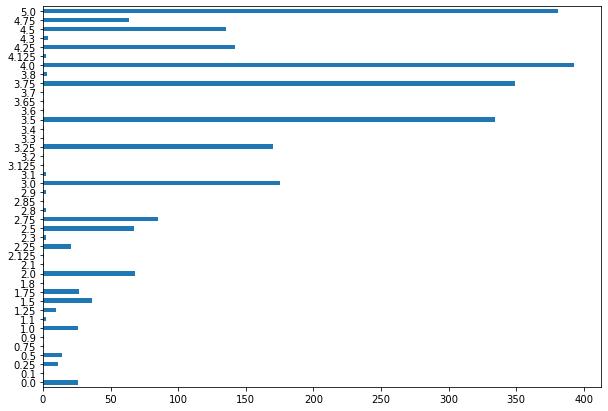

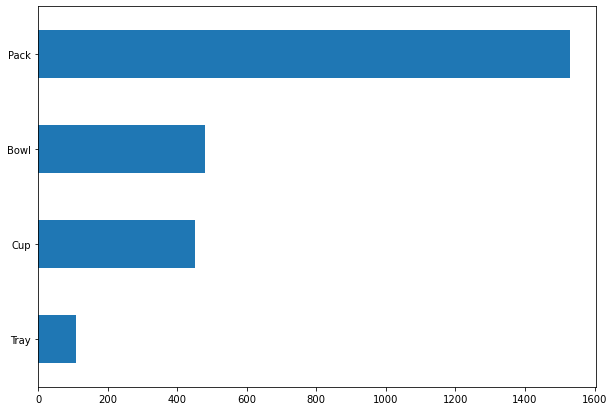

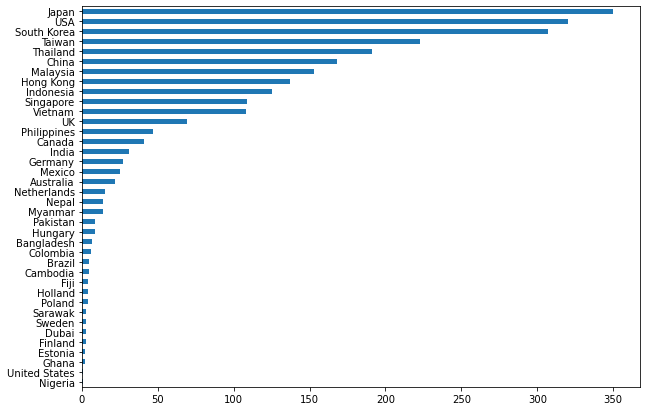

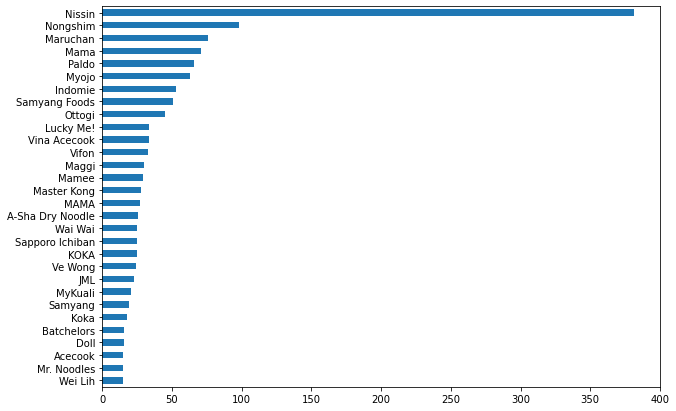

In [21]:
### Plot distributions ###
## Count by Stars ##
plt.figure(figsize=(10,7))
df.Stars.value_counts().sort_index().plot(kind='barh')
plt.show()
## Count by Styles ##
plt.figure(figsize=(10,7))
df.Style.value_counts(ascending=True).plot(kind='barh')
plt.show()
## Count by Country ##
plt.figure(figsize=(10,7))
df.Country.value_counts(ascending=True).plot(kind='barh')
plt.show()
## Count by Brand ##
plt.figure(figsize=(10,7))
brand_array = df.Brand.value_counts(ascending=False)[:30].sort_values(ascending=True)
brand_array.plot(kind='barh')
plt.show()

# Split Data
Note: I noticed later on that some countries and brands only have a few reviews, so I'm dropping anything less than 10 for country counts and dropping brand as a feature until I can engineer a solution. (First up is the MVP)

In [22]:
# df.Country.value_counts()
df = df.groupby('Country').filter(lambda x: len(x) > 10)

In [23]:
### Split into subsets ###
train_validate, test = train_test_split(df, test_size=0.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=123)
### Isolate targets ###
X_train, y_train = train.drop(columns='Stars'), train.Stars
X_validate, y_validate = validate.drop(columns='Stars'), validate.Stars
X_test, y_test = test.drop(columns='Stars'), test.Stars

# Explore Data

## Do bowls rank statistically higher than cups?
Confidence interval: 95%

$H_0$: Bowls do not rank statistically higher than cups.

$H_a$: Bowls rank statistically higher than cups.

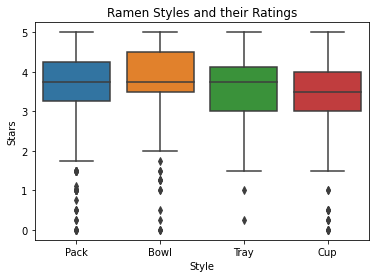

In [24]:
### Visualize Comparison ###
sns.boxplot(data=train, x='Style', y='Stars')
plt.title('Ramen Styles and their Ratings')
plt.show()

In [25]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(train[train.Style == 'Bowl'].Stars, 
                          train[train.Style == 'Cup'].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Bowls rank statistically higher than cups. We reject the null hypothesis with 95% confidence.')
else:
    print('Bowls do not rank statistically higher than cups. Results do not breach the 95% confidence threshold.')

Bowls rank statistically higher than cups. We reject the null hypothesis with 95% confidence.


## Does Japan produce better ramen than USA?
Confidence interval: 95%

$H_0$: Japan does not statistically produce better-rated ramen than USA.

$H_a$: Japan statistically produces better-rated ramen than USA.

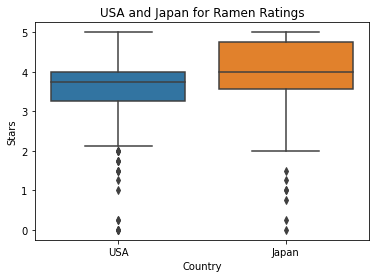

In [26]:
### Visualize comparison ##
sns.boxplot(data=train[(train.Country == 'Japan') | (train.Country == 'USA')], 
           x='Country',
           y='Stars')
plt.title('USA and Japan for Ramen Ratings')
plt.show()

In [27]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(train[train.Country == 'Japan'].Stars, 
                          train[train.Country == 'USA'].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Japan statistically produces better-rated ramen than USA.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Japan does not statistically produce better-rated ramen than USA.\n\
            Results do not breach the 95% confidence threshold.')

Japan statistically produces better-rated ramen than USA.
            We reject the null hypothesis with 95% confidence.


## Does Japan produce better ramen than the countries with over 100 ramen reviews?
Confidence interval: 95%

$H_0$: Japan does not statistically produce better-rated ramen than USA.

$H_a$: Japan statistically produces better-rated ramen than USA.

In [28]:
### Get Country Names (top 11 countries have over 100 ramen reviews) ###
countries = train.Country.value_counts()[:11].index.to_list()

In [29]:
### Put top 11 countries to new dataframe ###
train_top11 = train[train.Country == 'Japan']
for country in countries[1:]:
    train_top11 = train_top11.append(train[train.Country == country])
train_top11.Country.unique()

array(['Japan', 'USA', 'South Korea', 'Taiwan', 'Thailand', 'China',
       'Malaysia', 'Hong Kong', 'Indonesia', 'Singapore', 'Vietnam'],
      dtype=object)

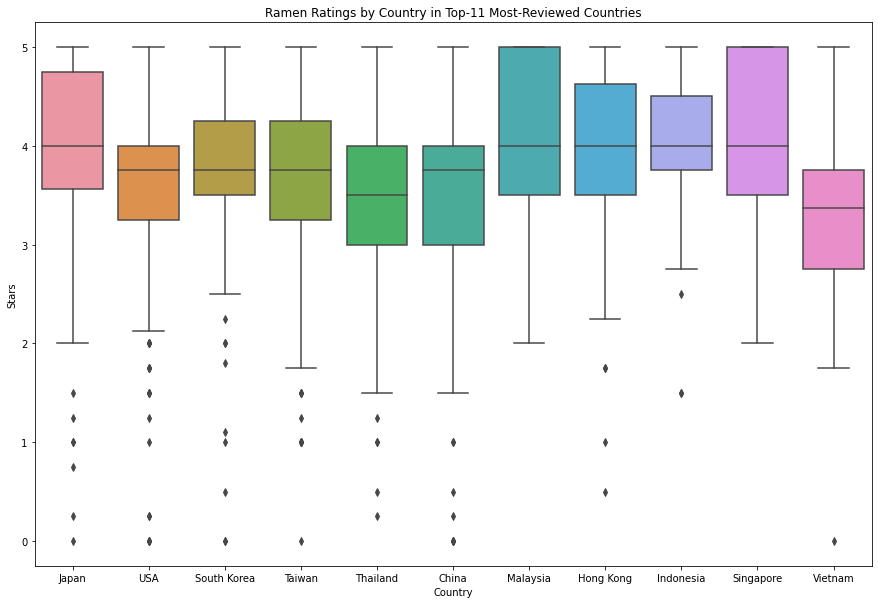

In [30]:
### Visualize Comparisons of top 11 Countries ###
plt.figure(figsize=(15,10))
sns.boxplot(data=train_top11, x='Country', y='Stars')
plt.title('Ramen Ratings by Country in Top-11 Most-Reviewed Countries')
plt.show()

In [31]:
### Create new column is_Japan ###
train_top11['is_Japan'] = train_top11.Country == 'Japan'
train_top11.sample(5)

,Review #,Brand,Variety,Style,Country,Stars,is_Japan
1996,584,Baijia,Single Noble Black Bone Chicken Sweet Potato T...,Cup,China,0.00,False
2339,241,Fu Chang Chinese Noodle Company,Hot & Spicy Beef,Tray,USA,4.00,False
471,2109,Oni Hot Pot,Tuna With Shallot Flavor Noodle,Pack,Taiwan,4.30,False
1721,859,Tradition,Imitation Chicken Vegetarian,Cup,USA,3.75,False
1443,1137,Koka,Oriental Style Instant Noodles Crab Flavour,Pack,Singapore,3.75,False


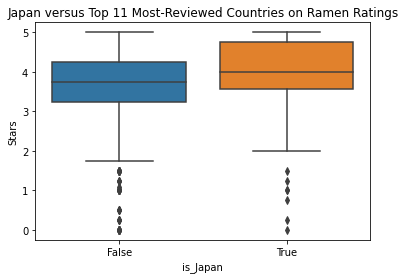

In [32]:
### Visualize Comparison between Japan and all of top 11 ###
sns.boxplot(data=train_top11, x='is_Japan', y='Stars')
plt.title('Japan versus Top 11 Most-Reviewed Countries on Ramen Ratings')
plt.show()

In [33]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(train_top11[train_top11.is_Japan == True].Stars, 
                          train_top11[train_top11.is_Japan == False].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Japan statistically produces better-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Japan does not statistically produce better-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Japan statistically produces better-rated ramen than the rest.
            We reject the null hypothesis with 95% confidence.


## Does Nissin produce better ramen than the next 8 most-reviewed brands?
Confidence interval: 95%

$H_0$: Nissin does not statistically produce better-rated ramen than other brands.

$H_a$: Nissin statistically produces better-rated ramen than other brands.

In [34]:
### Discover top 9 most-reviewed brands ###
df_9brands = brand_array.sort_values(ascending=False)[:9]
df_9brands

Nissin           381
Nongshim          98
Maruchan          76
Mama              71
Paldo             66
Myojo             63
Indomie           53
Samyang Foods     51
Ottogi            45
Name: Brand, dtype: int64

In [35]:
### Push brands to list ###
brand_list = df_9brands.index.to_list()
### Initialize dataframe ###
train_9brands = train[train.Brand == 'Nissin']
### Append remaining 8 brands' data to dataframe ###
for brand in brand_list[1:]:
    train_9brands = train_9brands.append(train[train.Brand == brand])
    
train_9brands.Brand.unique()

array(['Nissin', 'Nongshim', 'Maruchan', 'Mama', 'Paldo', 'Myojo',
       'Indomie', 'Samyang Foods', 'Ottogi'], dtype=object)

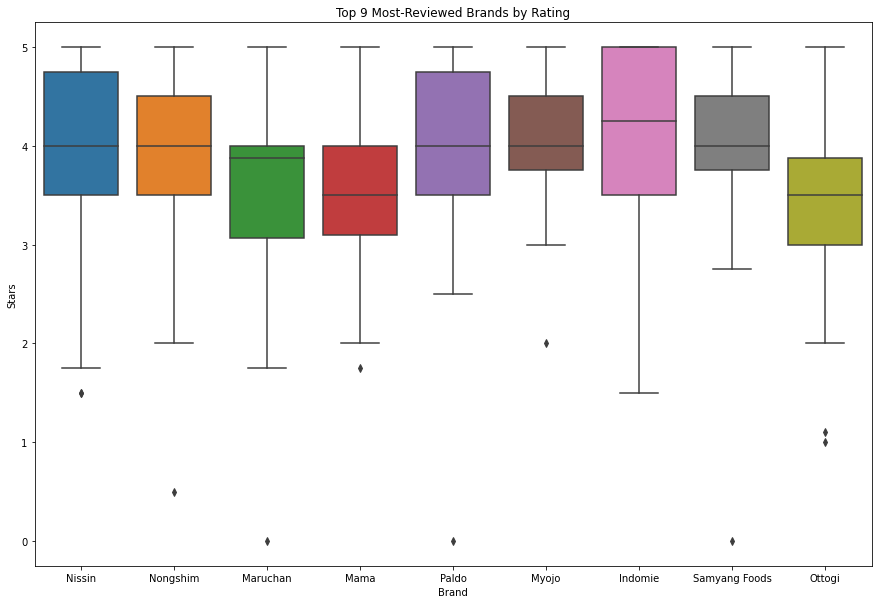

In [36]:
### Plot all brands individually against their ratings ###
plt.figure(figsize=(15,10))
sns.boxplot(data=train_9brands, x='Brand', y='Stars')
plt.title('Top 9 Most-Reviewed Brands by Rating')
plt.show()

In [37]:
### New column for is_Nissin ###
train_9brands['is_Nissin'] = train_9brands.Brand == 'Nissin'
train_9brands.sample(3)

,Review #,Brand,Variety,Style,Country,Stars,is_Nissin
664,1916,Nissin,Soba Fried Noodles Teriyaki,Pack,Germany,3.0,True
2289,291,Nongshim,Shin Bowl,Bowl,South Korea,3.0,False
290,2290,Nissin,Demae Ramen Straight Noodle Black Garlic Oil T...,Pack,Hong Kong,5.0,True


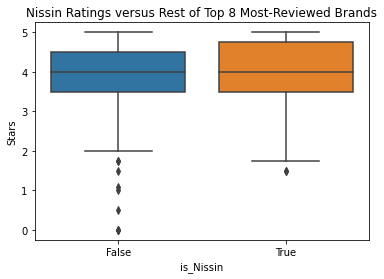

In [38]:
### Plot comparison ###
sns.boxplot(data=train_9brands, x='is_Nissin', y='Stars')
plt.title('Nissin Ratings versus Rest of Top 8 Most-Reviewed Brands')
plt.show()

In [39]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(train_9brands[train_9brands.is_Nissin == True].Stars, 
                          train_9brands[train_9brands.is_Nissin == False].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Nissin statistically produces better-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Nissin does not statistically produce better-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Nissin does not statistically produce better-rated ramen than the rest.
            Results do not breach the 95% confidence threshold.


## What do the 5-Star Reviews look like?

### By Country

In [40]:
### Create new dataframe for countries and 5-star value counts ###
five_star_country_counts = pd.DataFrame(train[train.Stars == 5].Country.value_counts()).reset_index()
five_star_country_counts.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
index,Japan,Malaysia,South Korea,Taiwan,Singapore,Hong Kong,USA,Thailand,Indonesia,China,Myanmar,Philippines,UK,India,Canada,Nepal,Germany,Vietnam
Country,43,31,27,21,20,18,17,12,11,5,2,2,2,2,1,1,1,1


In [41]:
### Create count of all reviews per country and merge to count of 5-stars ###
country_counts = pd.DataFrame(train.Country.value_counts()).reset_index()
five_star_country_counts = pd.merge(five_star_country_counts, country_counts, 
                                    left_on='index',
                                    right_on='index')
five_star_country_counts.head(3)

,index,Country_x,Country_y
0,Japan,43,210
1,Malaysia,31,93
2,South Korea,27,173


In [42]:
### Calculate percentage of 5-star reviews to all reviews ###
five_star_country_counts['fiver_percent_of_total'] = five_star_country_counts.Country_x / five_star_country_counts.Country_y
five_star_country_counts

,index,Country_x,Country_y,fiver_percent_of_total
0,Japan,43,210,0.204762
1,Malaysia,31,93,0.333333
2,South Korea,27,173,0.156069
3,Taiwan,21,139,0.151079
4,Singapore,20,75,0.266667
5,Hong Kong,18,79,0.227848
6,USA,17,194,0.087629
7,Thailand,12,125,0.096000
8,Indonesia,11,79,0.139241
9,China,5,101,0.049505


In [43]:
### Sort by percentage ###
five_star_country_counts[:8].sort_values('fiver_percent_of_total', ascending=False)

,index,Country_x,Country_y,fiver_percent_of_total
1,Malaysia,31,93,0.333333
4,Singapore,20,75,0.266667
5,Hong Kong,18,79,0.227848
0,Japan,43,210,0.204762
2,South Korea,27,173,0.156069
3,Taiwan,21,139,0.151079
7,Thailand,12,125,0.096000
6,USA,17,194,0.087629


### By Brand

In [44]:
### Check number of 5-star reviews by brand ###
train[train.Stars == 5].Brand.value_counts()

Nissin          52
Nongshim        11
MyKuali         10
Indomie          9
Paldo            9
                ..
Happy Cook       1
Wang             1
Itsuki           1
Ottogi           1
Urban Noodle     1
Name: Brand, Length: 77, dtype: int64

In [45]:
### Create dataframe of brands and their number of 5-star reviews ###
five_star_brand_counts = pd.DataFrame(train[train.Stars == 5].Brand.value_counts()).reset_index()
five_star_brand_counts.T

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
index,Nissin,Nongshim,MyKuali,Indomie,Paldo,Samyang Foods,Mama,KOKA,Maruchan,CarJEN,...,Dream Kitchen,Yamachan,Chering Chang,Ibumie,Daikoku,Happy Cook,Wang,Itsuki,Ottogi,Urban Noodle
Brand,52,11,10,9,9,7,7,5,5,5,...,1,1,1,1,1,1,1,1,1,1


In [46]:
### Affix dataframe of total review counts per brand to dataframe containing 5-star counts ###
brand_counts = pd.DataFrame(train.Brand.value_counts()).reset_index()
five_star_brand_counts = pd.merge(five_star_brand_counts, brand_counts, 
                                    left_on='index',
                                    right_on='index')
five_star_brand_counts.head(3)

,index,Brand_x,Brand_y
0,Nissin,52,221
1,Nongshim,11,62
2,MyKuali,10,12


In [47]:
### Calculate proportion of 5-star reviews to all reviews ###
five_star_brand_counts['fiver_percent_of_total'] = five_star_brand_counts.Brand_x / five_star_brand_counts.Brand_y
five_star_brand_counts

,index,Brand_x,Brand_y,fiver_percent_of_total
0,Nissin,52,221,0.235294
1,Nongshim,11,62,0.177419
2,MyKuali,10,12,0.833333
3,Indomie,9,33,0.272727
4,Paldo,9,37,0.243243
...,...,...,...,...
72,Happy Cook,1,3,0.333333
73,Wang,1,3,0.333333
74,Itsuki,1,3,0.333333
75,Ottogi,1,27,0.037037


In [48]:
### Sort by percentage ###
five_star_brand_counts[:8].sort_values('fiver_percent_of_total', ascending=False)

,index,Brand_x,Brand_y,fiver_percent_of_total
2,MyKuali,10,12,0.833333
7,KOKA,5,17,0.294118
3,Indomie,9,33,0.272727
4,Paldo,9,37,0.243243
0,Nissin,52,221,0.235294
5,Samyang Foods,7,33,0.212121
6,Mama,7,38,0.184211
1,Nongshim,11,62,0.177419


MyKuali has a suspiciously-high number of 5-star reviews... what's the distribution of all MyKuali reviews?

<AxesSubplot:xlabel='Brand', ylabel='Stars'>

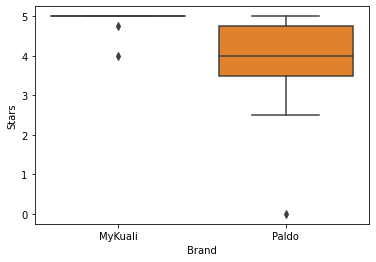

In [49]:
### Compare boxplots of MyKuali to next high-5-star-proprtion ramen brand ###
sns.boxplot(data=train, x=train[(train.Brand == 'MyKuali') | ((train.Brand == 'Paldo'))].Brand, y=train.Stars)

In [50]:
### Sanity check on high-review MyKuali ###
train[train.Brand == 'MyKuali']

,Review #,Brand,Variety,Style,Country,Stars
599,1981,MyKuali,Penang Red tom Yum Goong Noodle Authentic Taste,Pack,Malaysia,5.00
757,1823,MyKuali,MeeKuali spicy Fried Noodle,Pack,Malaysia,4.00
176,2404,MyKuali,Penang Hokkien Prawn Noodle Soup,Pack,Singapore,5.00
530,2050,MyKuali,Penang Red Tom Yum Goong Noodle Authentic Taste,Cup,Malaysia,5.00
591,1989,MyKuali,Penang White curry Noodle Authentic Taste,Pack,Malaysia,5.00
554,2026,MyKuali,Penang White Curry Authentic Taste Cup,Cup,Malaysia,4.75
963,1617,MyKuali,Penang Hokkien Prawn Noodle (New Improved Taste),Pack,Malaysia,5.00
799,1781,MyKuali,Penang Hokkien Prawn Soup Rice Vermicelli (Bihun),Bowl,Malaysia,5.00
732,1848,MyKuali,Penang Red tom Yum Goong Noodle (New Version),Pack,Malaysia,5.00
489,2091,MyKuali,Penang Hokkien Prawn Noodle Authentic Taste,Cup,Malaysia,5.00


<AxesSubplot:xlabel='Country', ylabel='Stars'>

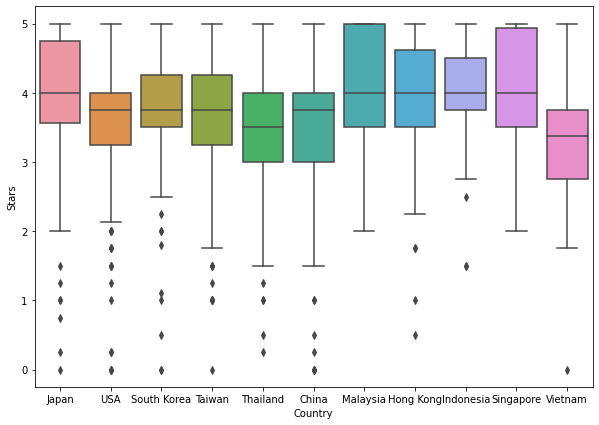

In [51]:
### Plot top-11 countries *without MyKuali* to see what happens to distribution ###
plt.figure(figsize=(10,7))
mykuali_indices = train_top11[train_top11.Brand == 'MyKuali'].index
sns.boxplot(data=train_top11.drop(index=mykuali_indices), x='Country', y='Stars')

It seems Malaysia's distribution didn't change much. Maybe Malaysia is just really good at making ramen.

# Modeling
Gameplan: 
1. Filter dataframe to 0.25 increments between 0 and 5 - *Done*
2. Multiply all values by 4 (0 -> 0, 0.25 -> 1, 0.5 -> 2, 0.75 -> 3, etc) - *Done*
3. Choose most common rating for baseline (classification approach, will explain my reasoning below) - *Done*
4. Calculate baseline accuracy (number of chosen-baseline values / all values) - *Done*
5. Build MVP models using Style and Country all encoded
    * Later perform Feature Engineering on Brand to simplify column for brand names only
    * Later perform Feature Engineering on Variety to simplify column for Chicken, Beef, etc
6. Evaluate models on validate set
7. Re-set baseline accuracy using best-selected model for train and validate
8. Feature engineering on Variety
9. One-hot encoding on all engineered Variety values and all Brand, Style, and Country values (yep)
10. SelectKBest/RFE to determine which features to use in model
11. Note which features SelectKBest/RFE chose
12. Build models using the features
13. Evaluate on validate
14. Compare to new baseline
15. Choose best model
16. Evaluate on test
17. Formalize results in a presentation notebook

## Prep

In [52]:
train.Stars.unique()

array([4.25 , 3.5  , 4.   , 5.   , 3.75 , 1.   , 2.75 , 4.75 , 3.25 ,
       4.5  , 0.   , 2.5  , 2.   , 1.75 , 3.   , 1.25 , 2.25 , 0.5  ,
       1.5  , 2.85 , 0.75 , 4.3  , 3.8  , 0.25 , 2.1  , 2.8  , 1.8  ,
       1.1  , 2.125, 2.9  , 3.1  , 4.125, 3.3  , 3.6  , 3.125, 3.7  ,
       2.3  ])

In [53]:
train['Stars'] = (train.Stars * 4).round() / 4
validate['Stars'] = (validate.Stars * 4).round() / 4
test['Stars'] = (test.Stars * 4).round() / 4

In [54]:
# Checking work
train.Stars.unique()

array([4.25, 3.5 , 4.  , 5.  , 3.75, 1.  , 2.75, 4.75, 3.25, 4.5 , 0.  ,
       2.5 , 2.  , 1.75, 3.  , 1.25, 2.25, 0.5 , 1.5 , 0.75, 0.25])

In [55]:
train[train.Stars.isna()]

,Review #,Brand,Variety,Style,Country,Stars


In [56]:
# Multiplying all values by 4 (0.25 -> 1, 0.5 -> 2, 0.75 -> 3, ...)
print(train.Stars[:5])
train['Stars'] = train.Stars * 4
validate['Stars'] = validate.Stars * 4
test['Stars'] = test.Stars * 4
print(train.Stars[:5])

594     4.25
1828    3.50
1611    4.00
215     5.00
1003    3.75
Name: Stars, dtype: float64
594     17.0
1828    14.0
1611    16.0
215     20.0
1003    15.0
Name: Stars, dtype: float64


In [57]:
train.Stars.unique()

array([17., 14., 16., 20., 15.,  4., 11., 19., 13., 18.,  0., 10.,  8.,
        7., 12.,  5.,  9.,  2.,  6.,  3.,  1.])

In [58]:
# Casting Stars column as int
train['Stars'] = train['Stars'].astype('int')
train['Stars'].dtype

dtype('int64')

In [59]:
# Discover most common rating (will use as baseline)
train['Stars'].value_counts().head(1)

16    229
Name: Stars, dtype: int64

In [60]:
# 4-star rating is most common, set to value 16
most_common = 16

## Minimum Viable Product (MVP)

In [61]:
# Calculate baseline accuracy
print('Baseline accuracy:', str(round((237 / len(train)) * 100, 2)) + '%')

Baseline accuracy: 15.83%


**MVP Columns**: Brand, Style, Country

One-hot encode columns

In [62]:
train_encoded = pd.get_dummies(train, columns=['Style','Country']).drop(columns=['Brand','Review #','Variety'])
validate_encoded = pd.get_dummies(validate, columns=['Style','Country']).drop(columns=['Brand','Review #','Variety'])
test_encoded = pd.get_dummies(test, columns=['Style','Country']).drop(columns=['Brand','Review #','Variety'])

In [63]:
train_encoded.head(1)

,Stars,Style_Bowl,Style_Cup,Style_Pack,Style_Tray,Country_Australia,Country_Canada,Country_China,Country_Germany,Country_Hong Kong,...,Country_Nepal,Country_Netherlands,Country_Philippines,Country_Singapore,Country_South Korea,Country_Taiwan,Country_Thailand,Country_UK,Country_USA,Country_Vietnam
594,17,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [64]:
X_train, y_train = train_encoded.drop(columns='Stars'), train_encoded.Stars
X_validate, y_validate = validate_encoded.drop(columns='Stars'), validate_encoded.Stars
X_test, y_test = test_encoded.drop(columns='Stars'), test_encoded.Stars
X_test.head(1)

,Style_Bowl,Style_Cup,Style_Pack,Style_Tray,Country_Australia,Country_Canada,Country_China,Country_Germany,Country_Hong Kong,Country_India,...,Country_Nepal,Country_Netherlands,Country_Philippines,Country_Singapore,Country_South Korea,Country_Taiwan,Country_Thailand,Country_UK,Country_USA,Country_Vietnam
1299,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
rf = RandomForestClassifier(n_estimators=2, random_state=99)
rf.fit(X_train, y_train)
print((rf.predict(X_train) == y_train).mean())
print((rf.predict(X_validate) == y_validate).mean())

0.23714094856379425
0.2124248496993988


In [66]:
tree = DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, random_state=123)
tree.fit(X_train, y_train)
print((tree.predict(X_train) == y_train).mean())
print((tree.predict(X_validate) == y_validate).mean())

0.23647294589178355
0.22244488977955912


In [67]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print((knn.predict(X_train) == y_train).mean())
print((knn.predict(X_validate) == y_validate).mean())

0.20975283901135605
0.17635270541082165


In [68]:
logit = LogisticRegression(random_state=123)
logit.fit(X_train, y_train)
print((logit.predict(X_train) == y_train).mean())
print((logit.predict(X_validate) == y_validate).mean())

0.21977287909151635
0.19238476953907815


## Results of MVP
- All algorithms performed better than the baseline.
- DecisionTreeClassifier with max_depth=16 and min_samples_leaf=4 performed best of all classification algorithms tried.

In [69]:
# Classification report
print(classification_report(y_train, tree.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00         4
           6       0.13      0.21      0.16        19
           7       0.00      0.00      0.00        17
           8       0.23      0.12      0.16        42
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00        33
          11       0.00      0.00      0.00        53
          12       0.19      0.11      0.14       111
          13       0.00      0.00      0.00        92
          14       0.25      0.45      0.32       186
          15       0.24      0.38      0.30       224
          16       0.22      0.32      0.26       229
          17       0.00    

Values 6, 8, 12, 14, 15, 16, and 20 had better-than-0% prediction (ratings: 1.5, 2, 3, 3.5, 3.75, 4, and 5), try a different classification report to see what it did?

In [70]:
# print(classification_report(y_train, rf.predict(X_train))) # 2, 6, 8, 11, 12, 13, 14, 15, 16, 20 (10 in total)
# print(classification_report(y_train, knn.predict(X_train))) # 7, 8, 11, 12, 13, 14, 15, 16, 17, 19, 20 (11 in total)
# print(classification_report(y_train, logit.predict(X_train))) # 8, 12, 14, 15, 16, 20 (6 in total)

So this is the result of using Style and Country only, peaking at around 22% for out-of-sample data. MORE FEATURES!

# Feature Engineering
## Brand
Pretty easy fix, just limit column to brands with over 10 reviews
### Prep

In [71]:
# Brands with more than 10 reviews
df = df.groupby('Brand').filter(lambda x: len(x) > 10)

In [72]:
# Re-split data
### Split into subsets ###
train_validate, test = train_test_split(df, test_size=0.2, random_state=124, stratify=df.Brand)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=124, stratify=train_validate.Brand)
### Isolate targets ###
X_train, y_train = train.drop(columns='Stars'), train.Stars
X_validate, y_validate = validate.drop(columns='Stars'), validate.Stars
X_test, y_test = test.drop(columns='Stars'), test.Stars

In [73]:
train['Stars'] = (train.Stars * 4).round()
validate['Stars'] = (validate.Stars * 4).round()
test['Stars'] = (test.Stars * 4).round()

In [74]:
# Discover most common rating (will use as baseline)
train['Stars'].value_counts().head(1)

20.0    167
Name: Stars, dtype: int64

In [75]:
# 4-star rating is most common, set to value 16
most_common = 16

In [76]:
# Calculate baseline accuracy
print('Baseline accuracy:', str(round((164 / len(train)) * 100, 2)) + '%')

Baseline accuracy: 16.6%


In [77]:
### Encode data ###
train_encoded = pd.get_dummies(train, columns=['Brand','Style','Country']).drop(columns=['Review #','Variety'])
validate_encoded = pd.get_dummies(validate, columns=['Brand','Style','Country']).drop(columns=['Review #','Variety'])
test_encoded = pd.get_dummies(test, columns=['Brand','Style','Country']).drop(columns=['Review #','Variety'])

In [78]:
X_train, y_train = train_encoded.drop(columns='Stars'), train_encoded.Stars
X_validate, y_validate = validate_encoded.drop(columns='Stars'), validate_encoded.Stars
X_test, y_test = test_encoded.drop(columns='Stars'), test_encoded.Stars
X_test.head(1)

,Brand_A-Sha Dry Noodle,Brand_ABC,Brand_Acecook,Brand_Annie Chun's,Brand_Asian Thai Foods,Brand_Baijia,Brand_Batchelors,Brand_Deshome,Brand_Doll,Brand_Dragonfly,...,Country_Myanmar,Country_Nepal,Country_Philippines,Country_Singapore,Country_South Korea,Country_Taiwan,Country_Thailand,Country_UK,Country_USA,Country_Vietnam
2124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [79]:
rf = RandomForestClassifier(n_estimators=1, random_state=99)
rf.fit(X_train, y_train)
print((rf.predict(X_train) == y_train).mean())
print((rf.predict(X_validate) == y_validate).mean())

0.34210526315789475
0.18181818181818182


In [80]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, random_state=123)
tree.fit(X_train, y_train)
print((tree.predict(X_train) == y_train).mean())
print((tree.predict(X_validate) == y_validate).mean())

0.29048582995951416
0.15151515151515152


In [81]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print((knn.predict(X_train) == y_train).mean())
print((knn.predict(X_validate) == y_validate).mean())

0.3360323886639676
0.19090909090909092


In [82]:
logit = LogisticRegression(penalty='l2', random_state=123)
logit.fit(X_train, y_train)
print((logit.predict(X_train) == y_train).mean())
print((logit.predict(X_validate) == y_validate).mean())

0.31983805668016196
0.20303030303030303


### Results with unmodified Brand
On all 4 algorithms with varying hyperparameters, having Brand created an overfit situation causing the models to perform worse on out-of-sample data compared to models without Brand.

## Variety

In [83]:
df.head(3)

,Review #,Brand,Variety,Style,Country,Stars
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75
5,2575,Samyang Foods,Kimchi song Song Ramen,Pack,South Korea,4.75


### Artificial

In [84]:
df[df.Variety.str[:10] == 'Artificial'].Stars.mean()

3.3159574468085107

In [85]:
df[df.Variety.str[:10] != 'Artificial'].Stars.mean()

3.749594003747658

In [86]:
eng = df.copy()
eng['Artificial'] = df.Variety.str.contains('artificial', case=False)
#eng['Artificial'] = df.Variety.str[:10] == 'Artificial'
eng.sample(3)

,Review #,Brand,Variety,Style,Country,Stars,Artificial
612,1968,Nissin,Top Ramen Chicken Flavor Ramen Noodle Soup (Ne...,Pack,USA,3.5,False
1146,1434,Maggi,Hot Cup Perisa Kari,Cup,Malaysia,3.5,False
2163,417,Vifon,Tu Quy Spicy Beef,Pack,Vietnam,3.5,False


<AxesSubplot:xlabel='Artificial', ylabel='Stars'>

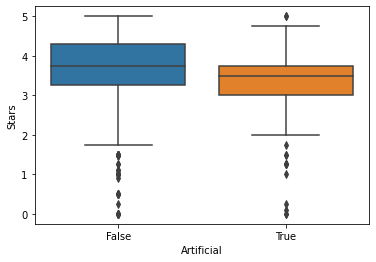

In [87]:
sns.boxplot(eng.Artificial, eng.Stars)

In [88]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Artificial == True].Stars, 
                          eng[eng.Artificial == False].Stars,
                          alternative='less')

if t > 0 and p < alpha:
    print('Artificial is worse-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Artificial is not worse-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Artificial is worse-rated ramen than the rest.
            We reject the null hypothesis with 95% confidence.


### Instant

In [89]:
eng['Instant'] = df.Variety.str.contains('instant', case=False)
eng.sample(3)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant
1806,774,Indomie,Rasa Sup Sayuran Vegan,Pack,Indonesia,2.25,False,False
2243,337,Maruchan,Ramen Noodle Soup Creamy Chicken,Pack,USA,5.00,False,False
1748,832,Dragonfly,Mee Goreng Dry Ramen Noodles,Pack,China,3.75,False,False


Instant: 3.808267716535433
Not-Instant: 3.7242826398852227


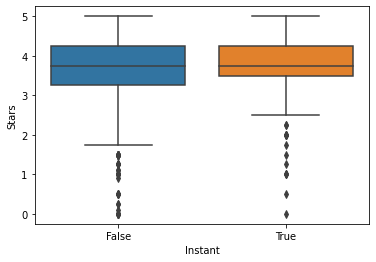

In [90]:
print("Instant:", eng[eng.Instant].Stars.mean())
print("Not-Instant:", eng[eng.Instant == False].Stars.mean())
sns.boxplot(eng.Instant, eng.Stars)
plt.show()

In [91]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Instant == True].Stars, 
                          eng[eng.Instant == False].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Instant is better-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Instant is not better-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Instant is not better-rated ramen than the rest.
            Results do not breach the 95% confidence threshold.


### Flavor (suggesting artificial?)

In [92]:
eng[eng.Variety.str.contains('flavor', case=False)].Variety.unique()

array(['GGE Ramen Snack Tomato Flavor',
       'Mr. Bibim Stir-Fried Kimchi Flavor',
       'Deka Buto Kimchi Pork Flavor',
       'Creamy Soup With Crushed Noodles Hot & Sour Fish Flavor',
       'Signature Tom Yum Flavor Instant Noodles',
       'Cup Noodles Very Veggie Spicy Chicken Flavor Ramen Noodle Soup',
       'Cup Noodles Very Veggie Beef Flavor Ramen Noodle Soup',
       'Cup Noodles Very Veggie Chicken Flavor Ramen Noodle Soup',
       'Mushroom Flavor',
       'Man Han Feast Spicy Beef Flavor Instant Noodles',
       'Delight Chicken Flavor Instant Non-Fried Noodles',
       'Creamy Soup With Crushed Noodles Chicken Flavor',
       'Ppushu Ppushu Noodle Snack Chilli Cheese Flavor',
       'Udon Japanese Style Noodles With Soup Base Hot & Sour Flavor',
       'Signature Curry Flavor Instant Noodles',
       'Creamy Soup With Crushed Noodles Sweet Corn Flavor',
       'Silk Beef Pho Flavor Instant Rice Fettuccine',
       'Delight Spicy Sesame Flavor Instant Non-Fried Noodle

Flavors:
- Tomato iii / Tomato Chicken i / Spicy Flavor Tomato i / Hot Tomato i
- Stir-Fried Kimchi ii
- Kimchi iii
- Stir Fry ii
- Chicken iiiiiiiiiiiiiiiiiiiiii / Spicy Chicken iii / Hot and Spicy Chicken ii / Hot and Sour Chicken i / Sweet and Sour Chicken i / Abalone and Chicken i / Sriracha Chicken ii / Mushroom Chicken i / Miso Chicken i / Chipotle Chicken i / Chicken Tortilla ii / Roast Chicken ii / Spicy Szechuan Chicken i / Grilled Chicken i / Chicken Vegetable i / Habanero Lime Chicken i / Lemon Chicken i
- Kimchi Pork ii / Braised Pork i / Minced Pork ii (mispelled Prok) i / Pork iiii / Stewed Pork i / BBQ Pork i / Pork Rib ii / Simmered Pork i / Tonkotsu/Shoyu Rich Pork
- Beef iiiiiiiiiiiiiiiiiii / Spicy Beef ii / Beef Pho i / Stewed Beef i / Pickled Vegetable Beef i / Tart Beef i / Braised Beef i / Sukiyaki Beef Flavor Savory Soy Sauce i / Beef Taco i / Beef Flavor Minestrone i
- Hot & Sour i
- Sour i
- Hot & Spicy i / Spicy Sichuan i
- Hot i
- Spicy i
- Spicy Po-Au-Feu ii
- Sriracha i
- Hot & Sour Fish i / Seafood iiii / Spicy Seafood iii / Seafood Flavor Udon i
- Shallot i
- Shrimp iii / Hot and Spicy Shrimp ii / Shrimp (Tom Yum) i (Shrimp Tom Yum) ii / Shrimp Habanero Lime i (Habanero Lime Shrimp) i / Picante Lime Shrimp i / Lime Flavor with Shrimp
- Prawn i
- Abalone Crab i
- Mushroom iiii
- Cheese ii / Jalapeno Cheddar i
- Pickled Mustard i
- Teriyaki Mayo i
- Sweet and Sour i
- Non-Fried i
- Chilli Cheese (mispelled) i / Chili & Lime i / Chilli Beef (mispelled) i / Sichuan Chilli Eel i / Hot Chili / Tom Yum Chili i
- Curry iiiii / Vegetable Curry i
- Sweet Corn i / Corn, Salt & Butter i
- Sesame ii / Spicy Sesame i / Sesame Oil i / Rice Vinegar Sesame i
- Spicy Black Pepper i
- Tom Yum ii
- Singapura i
- Onion iii
- Karashi Mentaiko i
- Tonkotsu i / Pork Tonkotsu / Umami Tonkotsu i / Tonkotsu Shouyu i / Shoyu i
- Jjamppong i
- Shiodare i
- Bulgogi i
- Shiitake Flavor Spinach i
- La Wei (Spicy i
- Wonton i / Wonton Soup i
- Shio i
- Hot Gulai i
- Mexican Pizza i
- Spicy Lime i
- Chow Mein i / Chow Mein Spicy i / Chow Mein Premium Spicy Chicken i / Chow Mein Oyster Sauce BBQ i / Chow Mein Seafood i / Chow Mein Teriyaki Chicken i
- Miso ii
- Umami Miso i / Umami Soy Sauce i
- Soy i / Soy Sauce i / Soy Sauce Flavor Udon i
- Udon i
- Camelia Oil Vegetable Sauce i / Camellia Oil Spicy Bean Sauce i
- Soy & Vinegar i
- Chili Picante Chicken With Lime Flavor i
- Abalone ii
- Bulalo i
- Pickled Cayenne i
- Vegetable ii / Vegetarian i
- Crab i
- Citrus i
- Original iii

Extra notes:
- with Vegetable / Vegetables iiii
- having Lime
- Sodium (having less)
- Simulated is used, add to Artificial
- is Tonkotsu
- is Shouyu / Shoyu
- is Miso
- is Abalone
- has Soy
- Tom Yum
- Meatball (a few with this characteristic)

Ideas:
- Traditional ramen flavors have better ratings than non-traditional flavors
- Meats v Vegetables/other
- Location-based (like Sichuan)

#### Potential Features from Flavor:
- Chicken (48); Beef (30); Pork (16); Shrimp (12); Fish/Seafood (10); Chow Mein (6);
- Chili/Chilli (7); Curry (6); Kimchi (5); Stir-Fry (4);
- Tom Yum (6); Tonkotsu (5); Miso (4); Wonton (2); Jjamppong (1); Shiodare (1); Bulgogi (1); Bulalo (1);
- Tomato (6); Mushroom (5); Sesame (5); Onion (3); Shiitake (1);
- Spicy (26); Hot (12); Soy (6); Sour (6); Sweet (2); Umami [savory] (2);
- Sriracha (3); 
- Abalone (4);
- Vegetable (11);
- has_Lime (8);

### Chicken

In [93]:
eng['Chicken'] = eng.Variety.str.contains('chicken', case=False)
eng.head(2)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,False,True
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,False,False


<AxesSubplot:xlabel='Chicken', ylabel='Stars'>

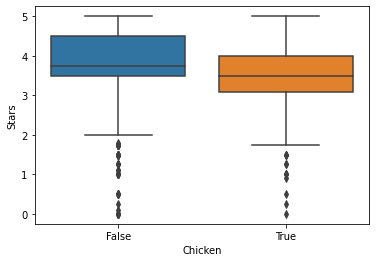

In [94]:
sns.boxplot(eng.Chicken, eng.Stars)

In [95]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Chicken == True].Stars, 
                          eng[eng.Chicken == False].Stars,
                          alternative='less')

if t > 0 and p < alpha:
    print('Chicken is worse-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Chicken is not worse-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Chicken is worse-rated ramen than the rest.
            We reject the null hypothesis with 95% confidence.


### Beef

In [96]:
eng['Beef'] = eng.Variety.str.contains('beef', case=False)
eng.head(2)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken,Beef
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,False,True,False
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,False,False,False


<AxesSubplot:xlabel='Beef', ylabel='Stars'>

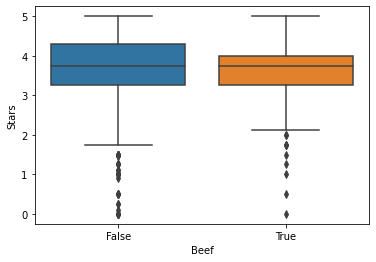

In [97]:
sns.boxplot(eng.Beef, eng.Stars)

In [98]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Beef == True].Stars, 
                          eng[eng.Beef == False].Stars,
                          alternative='less')

if t > 0 and p < alpha:
    print('Beef is worse-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Beef is not worse-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Beef is worse-rated ramen than the rest.
            We reject the null hypothesis with 95% confidence.


### Shrimp

In [99]:
eng['Shrimp'] = eng.Variety.str.contains('shrimp', case=False)
eng.head(2)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken,Beef,Shrimp
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,False,True,False,False
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,False,False,False,False


<AxesSubplot:xlabel='Shrimp', ylabel='Stars'>

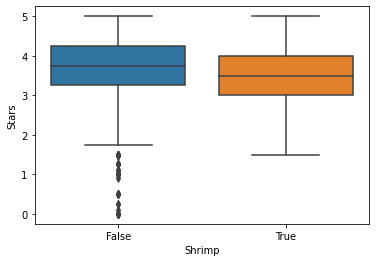

In [100]:
sns.boxplot(eng.Shrimp, eng.Stars)

In [101]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Shrimp == True].Stars, 
                          eng[eng.Shrimp == False].Stars,
                          alternative='less')

if t > 0 and p < alpha:
    print('Shrimp is worse-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Shrimp is not worse-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Shrimp is worse-rated ramen than the rest.
            We reject the null hypothesis with 95% confidence.


### Seafood

In [102]:
eng['Seafood'] = eng.Variety.str.contains('fish', case=False) | eng.Variety.str.contains('seafood', case=False)
eng.head(2)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken,Beef,Shrimp,Seafood
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,False,True,False,False,False
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,False,False,False,False,False


<AxesSubplot:xlabel='Seafood', ylabel='Stars'>

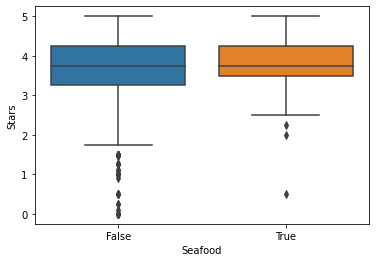

In [103]:
sns.boxplot(eng.Seafood, eng.Stars)

In [104]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Seafood == True].Stars, 
                          eng[eng.Seafood == False].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Seafood is better-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Seafood is not better-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Seafood is not better-rated ramen than the rest.
            Results do not breach the 95% confidence threshold.


### Chow Mein

In [105]:
eng['ChowMein'] = eng.Variety.str.contains('chow mein', case=False)
eng.head(2)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken,Beef,Shrimp,Seafood,ChowMein
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,False,True,False,False,False,False
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,False,False,False,False,False,False


<AxesSubplot:xlabel='ChowMein', ylabel='Stars'>

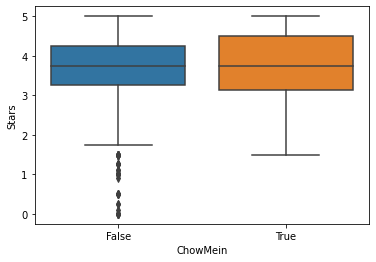

In [106]:
sns.boxplot(eng.ChowMein, eng.Stars)

In [107]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.ChowMein == True].Stars, 
                          eng[eng.ChowMein == False].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Chow Mein is better-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Chow Mein is not better-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Chow Mein is not better-rated ramen than the rest.
            Results do not breach the 95% confidence threshold.


### Spicy

In [108]:
eng['Spicy'] = eng.Variety.str.contains('spicy', case=False)
eng.head(2)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken,Beef,Shrimp,Seafood,ChowMein,Spicy
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,False,True,False,False,False,False,False
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,False,False,False,False,False,False,False


<AxesSubplot:xlabel='Spicy', ylabel='Stars'>

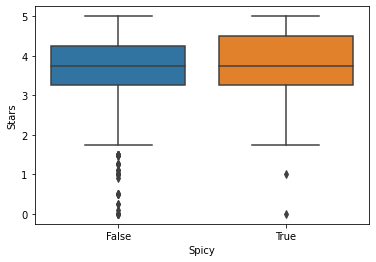

In [109]:
sns.boxplot(eng.Spicy, eng.Stars)

In [110]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Spicy == True].Stars, 
                          eng[eng.Spicy == False].Stars,
                          alternative='greater')

if t > 0 and p < alpha:
    print('Spicy is better-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Spicy is not better-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Spicy is not better-rated ramen than the rest.
            Results do not breach the 95% confidence threshold.


### Vegetable/Vegetarian

In [111]:
eng['Veggie'] = eng.Variety.str.contains('vegetable', case=False) | eng.Variety.str.contains('vegetarian', case=False)
eng.head(2)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken,Beef,Shrimp,Seafood,ChowMein,Spicy,Veggie
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,False,False,True,False,False,False,False,False,True
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,False,False,False,False,False,False,False,False,False


<AxesSubplot:xlabel='Veggie', ylabel='Stars'>

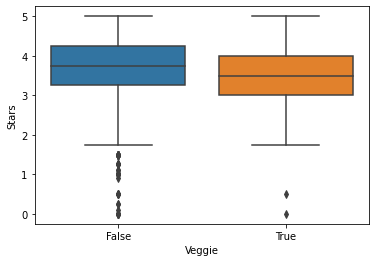

In [112]:
sns.boxplot(eng.Veggie, eng.Stars)

In [113]:
### Hypothesis Testing ###
alpha = .05
t, p = stats.mannwhitneyu(eng[eng.Veggie == True].Stars, 
                          eng[eng.Veggie == False].Stars,
                          alternative='less')

if t > 0 and p < alpha:
    print('Veggie is worse-rated ramen than the rest.\n\
            We reject the null hypothesis with 95% confidence.')
else:
    print('Veggie is not worse-rated ramen than the rest.\n\
            Results do not breach the 95% confidence threshold.')

Veggie is worse-rated ramen than the rest.
            We reject the null hypothesis with 95% confidence.


# Modeling - Post-MVP #1
## Prep

In [114]:
# eng.Country.value_counts() # Going to drop low value counts
eng = eng.drop([eng[eng.Country == 'Australia'].index.item()]) # Australia has one observation

In [115]:
# Encode
eng = pd.get_dummies(eng, columns=['Style'])
eng['Stars'] = (eng['Stars'] * 4).round() # Turn each 0.25-step into 1-step

## Split

In [116]:
# Specify columns to drop
columns_to_drop = ['Review #','Brand','Variety','Country']
# Split
train_validate, test = train_test_split(eng.drop(columns=columns_to_drop), test_size=0.2, random_state=99)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=99)
train.shape, validate.shape, test.shape

((987, 14), (330, 14), (330, 14))

In [117]:
# Check work
train.head(1)

,Stars,Artificial,Instant,Chicken,Beef,Shrimp,Seafood,ChowMein,Spicy,Veggie,Style_Bowl,Style_Cup,Style_Pack,Style_Tray
743,20.0,False,False,False,False,False,False,False,False,False,0,0,1,0


## Isolate Target

In [118]:
# Splits
X_train, y_train = train.drop(columns='Stars'), train.Stars
X_validate, y_validate = validate.drop(columns='Stars'), validate.Stars
X_test, y_test = test.drop(columns='Stars'), test.Stars

In [119]:
# Fix dtypes
X_train = X_train.astype('int')
X_validate = X_validate.astype('int')
X_test = X_test.astype('int')

## Model!

In [120]:
rf2 = RandomForestClassifier(n_estimators=1, random_state=99)
rf2.fit(X_train, y_train)
print((rf2.predict(X_train) == y_train).mean())
print((rf2.predict(X_validate) == y_validate).mean())

0.23910840932117527
0.17575757575757575


In [121]:
tree2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, random_state=123)
tree2.fit(X_train, y_train)
print((tree2.predict(X_train) == y_train).mean())
print((tree2.predict(X_validate) == y_validate).mean())

0.2857142857142857
0.14242424242424243


In [122]:
knn2 = KNeighborsClassifier(n_neighbors=20)
knn2.fit(X_train, y_train)
print((knn2.predict(X_train) == y_train).mean())
print((knn2.predict(X_validate) == y_validate).mean())

0.22188449848024316
0.18484848484848485


In [123]:
logit2 = LogisticRegression(random_state=123)
logit2.fit(X_train, y_train)
print((logit2.predict(X_train) == y_train).mean())
print((logit2.predict(X_validate) == y_validate).mean())

0.22391084093211752
0.2


### Results with new engineered features, not selecting k best or RFE
Logistic Regression performed best on out-of-sample data than other models, but did not perform as well as the MVP.

Let's see how adding Country column affects the results...

# Modeling - Post-MVP #2 (add Country)
## Prep

In [124]:
eng = pd.get_dummies(eng, columns=['Country'])
eng.head(1)

,Review #,Brand,Variety,Stars,Artificial,Instant,Chicken,Beef,Shrimp,Seafood,...,Country_Myanmar,Country_Nepal,Country_Philippines,Country_Singapore,Country_South Korea,Country_Taiwan,Country_Thailand,Country_UK,Country_USA,Country_Vietnam
2,2578,Nissin,Cup Noodles Chicken Vegetable,9.0,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,1,0


## Split

In [125]:
# Specify columns to drop
columns_to_drop = ['Review #','Brand','Variety']
# Split
train_validate, test = train_test_split(eng.drop(columns=columns_to_drop), test_size=0.2, random_state=99)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=99)
train.shape, validate.shape, test.shape

((987, 33), (330, 33), (330, 33))

## Isolate Target

In [126]:
# Splits
X_train, y_train = train.drop(columns='Stars'), train.Stars
X_validate, y_validate = validate.drop(columns='Stars'), validate.Stars
X_test, y_test = test.drop(columns='Stars'), test.Stars

In [127]:
# Encode
X_train = X_train.astype('int')
X_validate = X_validate.astype('int')
X_test = X_test.astype('int')

## Model!

In [128]:
rf3 = RandomForestClassifier(n_estimators=20, random_state=99)
rf3.fit(X_train, y_train)
print((rf3.predict(X_train) == y_train).mean())
print((rf3.predict(X_validate) == y_validate).mean())

0.49848024316109424
0.20909090909090908


In [129]:
tree3 = DecisionTreeClassifier(max_depth=20, min_samples_leaf=1, random_state=123)
tree3.fit(X_train, y_train)
print((tree3.predict(X_train) == y_train).mean())
print((tree3.predict(X_validate) == y_validate).mean())

0.47315096251266464
0.18484848484848485


In [130]:
knn3 = KNeighborsClassifier(n_neighbors=60)
knn3.fit(X_train, y_train)
print((knn3.predict(X_train) == y_train).mean())
print((knn3.predict(X_validate) == y_validate).mean())

0.26038500506585616
0.21515151515151515


In [131]:
logit3 = LogisticRegression(random_state=123)
logit3.fit(X_train, y_train)
print((logit3.predict(X_train) == y_train).mean())
print((logit3.predict(X_validate) == y_validate).mean())

0.26545086119554206
0.21515151515151515


### Results including Country, still not doing RFE or SelectKBest
KNN with 60 neighbors performed best by being not-overfit-as-much compared to Logistic Regression.

Now, let's run RFE to see if we can filter down features and improve model performance...

# Recursive Feature Engineering

In [132]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=20)

In [133]:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=20)

In [134]:
pd.Series(rfe.ranking_, index=X_train.columns)

Artificial              6
Instant                11
Chicken                 7
Beef                   13
Shrimp                  9
Seafood                12
ChowMein                8
Spicy                  10
Veggie                  5
Style_Bowl              4
Style_Cup               2
Style_Pack              3
Style_Tray              1
Country_Canada          1
Country_China           1
Country_Germany         1
Country_Hong Kong       1
Country_India           1
Country_Indonesia       1
Country_Japan           1
Country_Malaysia        1
Country_Mexico          1
Country_Myanmar         1
Country_Nepal           1
Country_Philippines     1
Country_Singapore       1
Country_South Korea     1
Country_Taiwan          1
Country_Thailand        1
Country_UK              1
Country_USA             1
Country_Vietnam         1
dtype: int64

That's interesting... it seems the countries all are more important in determining rating than any other feature, engineered or not. Hmm.

Well, let's approach this specifically from the Country column and see what happens.

# Modeling - Post-MVP #3 - Only Country
## Prep

In [135]:
# Set columns
new_approach = df[['Country','Stars']]

In [136]:
# Encode
new_approach = pd.get_dummies(new_approach, columns=['Country'])
new_approach['Stars'] = (new_approach['Stars'] * 4).round()

In [137]:
# Split
train_validate, test = train_test_split(new_approach, test_size=0.2, random_state=99)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=99)
train.shape, validate.shape, test.shape

((988, 21), (330, 21), (330, 21))

In [138]:
# Isolate target
X_train, y_train = train.drop(columns='Stars'), train.Stars
X_validate, y_validate = validate.drop(columns='Stars'), validate.Stars
X_test, y_test = test.drop(columns='Stars'), test.Stars

## Model!

In [139]:
rf3 = RandomForestClassifier(n_estimators=20, random_state=99)
rf3.fit(X_train, y_train)
print((rf3.predict(X_train) == y_train).mean())
print((rf3.predict(X_validate) == y_validate).mean())

0.23481781376518218
0.18787878787878787


In [140]:
tree3 = DecisionTreeClassifier(max_depth=20, min_samples_leaf=1, random_state=123)
tree3.fit(X_train, y_train)
print((tree3.predict(X_train) == y_train).mean())
print((tree3.predict(X_validate) == y_validate).mean())

0.23684210526315788
0.1787878787878788


In [141]:
knn3 = KNeighborsClassifier(n_neighbors=20)
knn3.fit(X_train, y_train)
print((knn3.predict(X_train) == y_train).mean())
print((knn3.predict(X_validate) == y_validate).mean())

0.21356275303643724
0.19090909090909092


In [142]:
logit3 = LogisticRegression(random_state=123)
logit3.fit(X_train, y_train)
print((logit3.predict(X_train) == y_train).mean())
print((logit3.predict(X_validate) == y_validate).mean())

0.23582995951417005
0.19393939393939394


### Modeling Results
Logistic Regression performed best, but not better than the MVP.

Since no feature combination breached 25% accuracy, I'm going to change up the target a bit. Instead of using 0.25 steps, I'm going to round the steps up to 1, so stars from 0 to 5.

# Modeling - Decrease Precision of Target
## Prep

In [143]:
y_train.unique()

array([20., 18., 14.,  6., 10., 12., 16.,  9., 11., 13., 15., 19., 17.,
        8.,  7.,  4.,  2.,  0.,  5.,  1.])

In [144]:
y_train = (y_train / 4).round()
y_validate = (y_validate / 4).round()
y_test = (y_test / 4).round()
y_train.unique()

array([5., 4., 2., 3., 1., 0.])

## Model!

In [145]:
rf3 = RandomForestClassifier(n_estimators=2, random_state=99)
rf3.fit(X_train, y_train)
print((rf3.predict(X_train) == y_train).mean())
print((rf3.predict(X_validate) == y_validate).mean())

0.5566801619433198
0.5424242424242425


In [146]:
tree3 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, random_state=123)
tree3.fit(X_train, y_train)
print((tree3.predict(X_train) == y_train).mean())
print((tree3.predict(X_validate) == y_validate).mean())

0.5516194331983806
0.5424242424242425


In [147]:
knn3 = KNeighborsClassifier(n_neighbors=70)
knn3.fit(X_train, y_train)
print((knn3.predict(X_train) == y_train).mean())
print((knn3.predict(X_validate) == y_validate).mean())

0.5516194331983806
0.5424242424242425


In [148]:
logit3 = LogisticRegression(random_state=123)
logit3.fit(X_train, y_train)
print((logit3.predict(X_train) == y_train).mean())
print((logit3.predict(X_validate) == y_validate).mean())

0.5566801619433198
0.5484848484848485


### Modeling Results
By decreasing the precision of the target by four times, the models performed twice as well as before. Let's re-calculate the baseline real quick to see if this new performance still beats threshold...

In [149]:
y_train.value_counts()

4.0    536
5.0    187
3.0    161
2.0     78
1.0     15
0.0     11
Name: Stars, dtype: int64

In [150]:
print("Baseline Accuracy:", 536 / len(y_train))

Baseline Accuracy: 0.5425101214574899


So baseline accuracy is 55.25%. When only using Country as a one-hot-encoded feature, all models had similar performance to the baseline (within 1% of baseline).

Let's try a different feature combination on this less-precise target.

# Modeling - Post-Precision Decrease
So since I've already prepared different feature combinations, I'm simply bringing the code up to this section.

## Brand
### Prep

In [151]:
### Decrease target's precision ###
df['Stars'] = df['Stars'].round().astype('int')
df.head(2)

,Review #,Brand,Variety,Style,Country,Stars
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,3


In [152]:
### Split into subsets ###
train_validate, test = train_test_split(df, test_size=0.2, random_state=124, stratify=df.Brand)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=124, stratify=train_validate.Brand)

In [153]:
### Encode data ###
train_encoded = pd.get_dummies(train, columns=['Brand','Style','Country']).drop(columns=['Review #','Variety'])
validate_encoded = pd.get_dummies(validate, columns=['Brand','Style','Country']).drop(columns=['Review #','Variety'])
test_encoded = pd.get_dummies(test, columns=['Brand','Style','Country']).drop(columns=['Review #','Variety'])

In [154]:
### Isolate target ###
X_train, y_train = train_encoded.drop(columns='Stars'), train_encoded.Stars
X_validate, y_validate = validate_encoded.drop(columns='Stars'), validate_encoded.Stars
X_test, y_test = test_encoded.drop(columns='Stars'), test_encoded.Stars

### Model!

In [155]:
rf_v2 = RandomForestClassifier(n_estimators=10, random_state=99)
rf_v2.fit(X_train, y_train)
print((rf_v2.predict(X_train) == y_train).mean())
print((rf_v2.predict(X_validate) == y_validate).mean())

0.6204453441295547
0.503030303030303


In [156]:
tree_v2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, random_state=123)
tree_v2.fit(X_train, y_train)
print((tree_v2.predict(X_train) == y_train).mean())
print((tree_v2.predict(X_validate) == y_validate).mean())

0.597165991902834
0.5606060606060606


In [157]:
knn_v2 = KNeighborsClassifier(n_neighbors=40)
knn_v2.fit(X_train, y_train)
print((knn_v2.predict(X_train) == y_train).mean())
print((knn_v2.predict(X_validate) == y_validate).mean())

0.5597165991902834
0.5454545454545454


In [158]:
logit_v2 = LogisticRegression(random_state=123)
logit_v2.fit(X_train, y_train)
print((logit_v2.predict(X_train) == y_train).mean())
print((logit_v2.predict(X_validate) == y_validate).mean())

0.5850202429149798
0.5515151515151515


### Results
Decision Tree had the best performance at 56% prediction of out-of-sample data. Let's try another feature combination.
## Variety
### Prep

In [159]:
# Initialize engineered dataframe
eng = df.copy()
# Add columns for Variety elements
eng['Artificial'] = df.Variety.str.contains('artificial', case=False)
eng['Instant'] = df.Variety.str.contains('instant', case=False)
eng['Chicken'] = eng.Variety.str.contains('chicken', case=False)
eng['Beef'] = eng.Variety.str.contains('beef', case=False)
eng['Shrimp'] = eng.Variety.str.contains('shrimp', case=False)
eng['Seafood'] = eng.Variety.str.contains('fish', case=False) | eng.Variety.str.contains('seafood', case=False)
eng['ChowMein'] = eng.Variety.str.contains('chow mein', case=False)
eng['Spicy'] = eng.Variety.str.contains('spicy', case=False)
eng['Veggie'] = eng.Variety.str.contains('vegetable', case=False) | eng.Variety.str.contains('vegetarian', case=False)
# Check work
eng.head(3)

,Review #,Brand,Variety,Style,Country,Stars,Artificial,Instant,Chicken,Beef,Shrimp,Seafood,ChowMein,Spicy,Veggie
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2,False,False,True,False,False,False,False,False,True
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,3,False,False,False,False,False,False,False,False,False
5,2575,Samyang Foods,Kimchi song Song Ramen,Pack,South Korea,5,False,False,False,False,False,False,False,False,False


In [160]:
# Encoding
eng = pd.get_dummies(eng, columns=['Style','Country']).drop(columns=['Review #','Brand','Variety'])

In [161]:
# Split
train_validate, test = train_test_split(eng, test_size=0.2, random_state=99)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=99)
train.shape, validate.shape, test.shape

((988, 34), (330, 34), (330, 34))

In [162]:
# Isolate target
X_train, y_train = train.drop(columns='Stars'), train.Stars
X_validate, y_validate = validate.drop(columns='Stars'), validate.Stars
X_test, y_test = test.drop(columns='Stars'), test.Stars

### Model!

In [163]:
rf_v2_1 = RandomForestClassifier(n_estimators=1, random_state=99)
rf_v2_1.fit(X_train, y_train)
print((rf_v2_1.predict(X_train) == y_train).mean())
print((rf_v2_1.predict(X_validate) == y_validate).mean())

0.6204453441295547
0.4303030303030303


In [164]:
tree_v2_1 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, random_state=123)
tree_v2_1.fit(X_train, y_train)
print((tree_v2_1.predict(X_train) == y_train).mean())
print((tree_v2_1.predict(X_validate) == y_validate).mean())

0.5576923076923077
0.5424242424242425


In [165]:
knn_v2_1 = KNeighborsClassifier(n_neighbors=40)
knn_v2_1.fit(X_train, y_train)
print((knn_v2_1.predict(X_train) == y_train).mean())
print((knn_v2_1.predict(X_validate) == y_validate).mean())

0.5526315789473685
0.5333333333333333


In [166]:
logit_v2_1 = LogisticRegression(random_state=123)
logit_v2_1.fit(X_train, y_train)
print((logit_v2_1.predict(X_train) == y_train).mean())
print((logit_v2_1.predict(X_validate) == y_validate).mean())

0.5678137651821862
0.5333333333333333


### Modeling Results
Decision Tree performed best of the models, but performed almost exactly the same as baseline.

# Goal Wrap-Up
Through this classification approach, I've been able to beat mean baseline on both the precise rating and imprecise rating target.